![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Classifying Names with a Character-Level RNN

We will be building and training a basic character-level RNN to classify words. A character-level RNN reads words as a series of characters - outputting a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

# Recommended Reading
It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

# Preparing the Data

Included in the `data/names` directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, `{language: [names ...]}`. The generic variables "category" and "line" (for language and name in our case) are used for later extensibility.

In [1]:
!rm -rf ./data/
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2020-05-19 16:33:40--  https://download.pytorch.org/tutorial/data.zip
Auflösen des Hostnamens download.pytorch.org (download.pytorch.org) … 99.84.158.112, 99.84.158.107, 99.84.158.103, ...
Verbindungsaufbau zu download.pytorch.org (download.pytorch.org)|99.84.158.112|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 2882130 (2,7M) [application/zip]
Wird in »data.zip.1« gespeichert.

data.zip.1          100%[===================>]   2,75M  2,95MB/s    in 0,9s    

2020-05-19 16:33:41 (2,95 MB/s) - »data.zip.1« gespeichert [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating

In [61]:
import glob

all_filenames = glob.glob('data/names/*.txt')
print(all_filenames)

['data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Scottish.txt', 'data/names/Italian.txt', 'data/names/Vietnamese.txt', 'data/names/Irish.txt', 'data/names/Russian.txt', 'data/names/German.txt', 'data/names/Czech.txt', 'data/names/Japanese.txt', 'data/names/Arabic.txt', 'data/names/Spanish.txt', 'data/names/Chinese.txt', 'data/names/Portuguese.txt', 'data/names/Greek.txt', 'data/names/English.txt', 'data/names/Polish.txt', 'data/names/French.txt']


In [62]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [63]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


Now we have `category_lines`, a dictionary mapping each category (language) to a list of lines (names). We also kept track of `all_categories` (just a list of languages) and `n_categories` for later reference.

In [64]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning Names into Tensors

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size `<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix `<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [65]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [66]:
print(letter_to_tensor('a'))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [67]:
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


# Creating the Network

Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very "pure" way, as regular feed-forward layers.

This RNN module (mostly copied from [the PyTorch for Torch users tutorial](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb)) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

In [68]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

## Manually testing the network

With our custom `RNN` class defined, we can create a new instance:

In [69]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We'll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

Remember that PyTorch modules operate on Variables rather than straight up Tensors.

In [70]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 18])


For the sake of efficiency we don't want to be creating a new Tensor for every step, so we will use `line_to_tensor` instead of `letter_to_tensor` and use slices. This could be further optimized by pre-computing batches of Tensors.

In [71]:
input = Variable(line_to_tensor('Albert'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9833, -2.8786, -2.9225, -2.8533, -2.8728, -2.9398, -2.7761, -2.9307,
         -2.9320, -2.8963, -2.9606, -2.8759, -2.8307, -2.9909, -2.8012, -2.8884,
         -2.8205, -2.9041]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a `<1 x n_categories>` Tensor, where every item is the likelihood of that category (higher is more likely).

# Preparing for Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:

In [72]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Russian', tensor(6))


We will also want a quick way to get a training example (a name and its language):

In [73]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Italian / line = Scordato
category = Czech / line = Neisser
category = German / line = Gabler
category = Irish / line = O'Hare
category = Vietnamese / line = Bui
category = Vietnamese / line = Vuong
category = French / line = Palomer
category = Czech / line = Ruda
category = Czech / line = Cerny
category = Spanish / line = Moreno


# Training the Network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the [loss function `nn.NLLLoss`](http://pytorch.org/docs/nn.html#nllloss) is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.

In [74]:
criterion = nn.NLLLoss()

We will also create an "optimizer" which updates the parameters of our model according to its gradients. We will use the vanilla SGD algorithm with a low learning rate.

In [75]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

Each loop of training will:

* Create input and target tensors
* Create a zeroed initial hidden state
* Read each letter in and
    * Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss

In [76]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the `train` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every `print_every` time steps, and take an average of the loss.

In [77]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.3910 Nifterik / Polish ✗ (Dutch)
10000 10% (0m 15s) 2.1351 Kessel / Czech ✓
15000 15% (0m 23s) 0.9134 Choi / Korean ✓
20000 20% (0m 31s) 2.4345 Dubhshlaine / Italian ✗ (Irish)
25000 25% (0m 39s) 2.5152 Kieu / Dutch ✗ (Vietnamese)
30000 30% (0m 47s) 0.4866 Thai / Vietnamese ✓
35000 35% (0m 55s) 3.8753 Ino / Chinese ✗ (Japanese)
40000 40% (1m 3s) 1.9450 Pinheiro / Japanese ✗ (Portuguese)
45000 45% (1m 11s) 2.1543 Aart / French ✗ (Dutch)
50000 50% (1m 19s) 1.2874 Zimmermann / Dutch ✗ (German)
55000 55% (1m 27s) 2.1280 Huff / Korean ✗ (German)
60000 60% (1m 35s) 3.0571 Kaluza / Arabic ✗ (Polish)
65000 65% (1m 43s) 2.1561 Silje / English ✗ (Dutch)
70000 70% (1m 51s) 1.0266 Aida / Japanese ✓
75000 75% (1m 59s) 0.9628 Chi / Korean ✓
80000 80% (2m 6s) 3.2452 Busto / Scottish ✗ (Spanish)
85000 85% (2m 14s) 1.7495 Glasby / Arabic ✗ (English)
90000 90% (2m 22s) 1.0844 Gorecki / Czech ✗ (Polish)
95000 95% (2m 30s) 0.0493 Stroggylis / Greek ✓
100000 100% (2m 38s) 1.5239 Stilo / Sc

# Plotting the Results

Plotting the historical loss from `all_losses` shows the network learning:

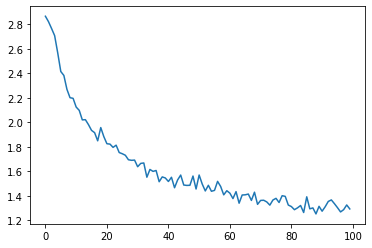

In [78]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

acc estimate 0.5827999711036682


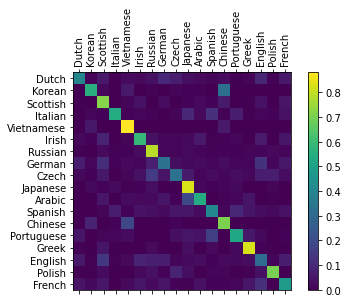

In [79]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# calculate the estimated accuracy
correct_predictions = 0
for i in range(n_categories):
    correct_predictions += confusion[i][i]
acc_estimate = correct_predictions / n_confusion
print("acc estimate "+str(acc_estimate.item()))

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

# Running on User Input

In [80]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Guhr')


> Dovesky
(-0.22) Russian
(-2.14) Czech
(-3.64) English

> Jackson
(-0.38) Scottish
(-1.89) Russian
(-2.06) English

> Satoshi
(-0.74) Japanese
(-1.86) Arabic
(-1.94) Polish

> Guhr
(-0.28) Chinese
(-2.50) German
(-2.66) Vietnamese


# Exercise 1

The RNN network above works but you can achive better results if you implement the network from our lesson. Modify the network code above and implement following formula:

  $h_t = tanh(W_{hh}h_{t-1}+W_{xh}x_t)$

  $y_t = W_{yh}h_t$

You should achive an accuracy score of about 0.7

# Bonus Exercise

Create a even better Network. Use the "LSTMCell" Class to implement a LSTM or GRU Model.

# Have some fun:

* Get better results with a bigger and/or better shaped network
    * Add more linear layers    
    * Combine multiple of these RNNs as a higher level network

* Try with a different dataset of line -> category, for example:
    * Any word -> language
    * First name -> gender
    * Character name -> writer
    * Page title -> blog or subreddit


**Next**: [Generating Shakespeare with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)